In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

#from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ
# To be modified: accessing utils

Gtk-Message: 07:57:52.771: Failed to load module "canberra-gtk-module"


In [2]:
## Copy of utils.py code, not necessary to run if the utils.py from Labs sessions is in the correct location (similar to previous weeks exos) 
async def importFSLasync():
    #load fsl module
    import lmod
    import os
    await lmod.purge(force=True)
    await lmod.load('fsl/6.0.7.4')
    await lmod.list()

def loadFSL():
    """
    Function to load FSL 6.0.7.4 module
    Ensures proper environment variables are setup.
    This function should be called at the start of any
    notebook which relies in any capacity on FSL.
    
    If you wish to change the FSL version being used,
    you should edit within the load AND FSLDIR the version.
    Make sure it exists in the neurodocker image before changing it!
    """
    import asyncio
    import os
    # We need to do the import asynchronously, as modules rely on await within
    #asyncio.run(importFSLasync())
    os.environ["FSLDIR"]="/cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.7.4_20231005/fsl_6.0.7.4_20231005.simg/opt/fsl-6.0.7.4/"
    os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"
    os.environ["SINGULARITY_BINDPATH"]="/data,/neurodesktop-storage,/tmp,/cvmfs"


def mkdir_no_exist(path):
    """
    Function to create a directory if it does not exist already.

    Parameters
    ----------
    path: string
        Path to create
    """
    import os
    import os.path as op
    if not op.isdir(path):
        os.makedirs(path)

class FSLeyesServer:
    """
    An FSL eyes class to manipulate frame and context across notebook.
    
    
    Attributes
    ----------
    overlayList: object
        List of overlays, the images displayed within FSLeyes. Each image is a separate overlay
    displayCtx: object
        Display context
    frame: object
        Frame used to display and interact with FSLeyes
    ortho: object
        View panel in orthographic mode
        
    Examples
    --------
    >>>> %gui wx # Do not forget to use this in a notebook!
    >>>> from utils import FSLeyesServer
    >>>> fsleyesDisplay = FSLeyesServer()
    >>>> fsleyesDisplay.show()
    
    It is not a server in the most proper sense, but merely a convenience wrapper.
    Before initializing this class, always make sure you call %gui wx in a cell of the notebook
    to enable GUI integration.
    """
    def __init__(self):
        import fsleyes
        from fsleyes.views.orthopanel import OrthoPanel
        overlayList, displayCtx, frame = fsleyes.embed()
        ortho = frame.addViewPanel(OrthoPanel)
        self.overlayList = overlayList
        self.displayCtx = displayCtx
        self.frame = frame
        self.ortho = ortho
    def show(self):
        """
        Show the current frame interactively.
        """
        self.frame.Show()

    def setOverlayCmap(self,overlayNbr,cmap):
        self.displayCtx.getOpts(self.overlayList[overlayNbr]).cmap = 'Render3'
    
    def resetOverlays(self):
        """
        Remove all overlays from the current frame
        """
        from fsleyes.views.orthopanel import OrthoPanel
    
        while len(self.overlayList) > 0:
            del self.overlayList[0]

        self.frame.removeViewPanel(self.frame.viewPanels[0])
        # Put back an ortho panel in our viz for future displays
        self.frame.addViewPanel(OrthoPanel)
    
    def load(self,image_path):
        """
        Add a Nifti image to the current frame as a new overlay

        Parameters
        ----------
        image_path:  string
            Path to the Nifti image to add to the frame.
            
        Example
        -------
        >>>> %gui wx # Do not forget to use this in a notebook!
        >>>> from utils import FSLeyesServer
        >>>> fsleyesDisplay = FSLeyesServer() 
        >>>> fsleyesDisplay.load(op.expandvars('$FSLDIR/data/standard/MNI152_T1_0.5mm'))
        >>>> fsleyesDisplay.show()
        """
        from fsl.data.image import Image
        import fsleyes.data.tractogram as trk
        if ".trk" in image_path:
            trk_overlay = trk.Tractogram(image_path)
            self.overlayList.append(trk_overlay)
        else:
            self.overlayList.append(Image(image_path))
    def close(self):
        """
        Closes the server and free up resources.
        """
        import fsleyes
    
        self.frame.Close()
        fsleyes.shutdown()

def fsleyes_thread():
    """
    Function to run the FSLeyesServer in a separate thread.
    This function keeps the server running indefinitely.
    """
    fsleyesDisplay = FSLeyesServer()
    fsleyesDisplay.show()
    
    # Keep the thread alive
    while True:
        time.sleep(1)


def get_json_from_file(fname):
    """
    Given a filename pointing to a json, returns the json's content.

    Parameters
    ----------
    fname: string
        The filename of the json file

    Returns
    -------
    The data of the json file
    """
    import json
    f = open(fname)
    data = json.load(f)
    f.close()
    return data


In [2]:

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [3]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

07:58:24: Debug: Adding duplicate image handler for 'Windows bitmap file'
07:58:24: Debug: Adding duplicate animation handler for '1' type
07:58:24: Debug: Adding duplicate animation handler for '2' type
07:58:25: Debug: Adding duplicate image handler for 'Windows bitmap file'
07:58:25: Debug: Adding duplicate animation handler for '1' type
07:58:25: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:1555): Gtk-CRITICAL **: 07:58:25.685: gtk_window_resize: assertion 'height > 0' failed
07:58:26: Debug: ScreenToClient cannot work when toplevel window is not shown
07:58:26: Debug: ScreenToClient cannot work when toplevel window is not shown
07:58:26: Debug: ScreenToClient cannot work when toplevel window is not shown
07:58:26: Debug: ScreenToClient cannot work when toplevel window is not shown
07:58:26: Debug: ScreenToClient cannot work when toplevel window is not shown
07:58:26: Debug: ScreenToClient cannot work when toplevel window is not shown
07:58:26: Deb

## 1.1 Downloading Data

In [4]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)


###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))

In [5]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))


(ipykernel_launcher.py:1555): Gdk-WARNING **: 08:00:57.714: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [7]:
print_dir_tree(bids_root, max_depth=4)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


## 1.2 Standardizing & Concatenating Data

In [15]:
# Finding the runs matching the structure run-*
fmri_paths = glob.glob(op.join(bids_root,'sub-control01', 'func', 'sub-control01_task-music_run-*_bold.nii.gz'))

# List to hold the standardized data arrays from each run
standardized_fmri_data = []

# Loop through each run file and load it
for i, run_path in enumerate(fmri_paths):
    img = nib.load(run_path)
    data = img.get_fdata()  # Extract the data as a numpy array
    
    # Standardize data (z-scoring)
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    print("Standardizing run {} with mean: {} and std: {}".format(i+1, round(mean,3), round(std,3)))
    
    # Append standardized data for concatenation
    standardized_fmri_data.append(standardized_data)

# Concatenate the standardized runs along the time dimension (4th dimension)
concatenated_data = np.concatenate(standardized_fmri_data, axis=3)

# Create a new NIfTI image for the concatenated data
concatenated_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)

# Save the concatenated image
nib.save(concatenated_img, op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))
print("Concatenation complete and saved as concatenated_bold.nii.gz")

Standardizing run 1 with mean: 191.366 and std: 353.0
Standardizing run 2 with mean: 191.759 and std: 354.386
Standardizing run 3 with mean: 191.214 and std: 352.308
Concatenation complete and saved as concatenated_bold.nii.gz


In [16]:
print("Resulting concatenated data has mean: {} and std: {}".format(round(np.mean(concatenated_data),3), round(np.std(concatenated_data),3)))

Resulting concatenated data has mean: -0.0 and std: 1.0


In [17]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ func/
|--------------- concatenated_bold.nii.gz
|--------------- concatenated_standardized_fmri.nii.gz
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


In [18]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))

## 1.3 Pre-processing Data

### 1.3.PP1 - Motion Correction

In [20]:
from fsl.wrappers import mcflirt

path_original_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [21]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ func/
|--------------- concatenated_bold.nii.gz
|--------------- concatenated_bold_moco.nii.gz
|--------------- concatenated_bold_moco.par
|--------------- concatenated_standardized_fmri.nii.gz
|--------------- concatenated_bold_moco.mat/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


In [22]:
# Looking at the time series
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

### Observing the motion correction parameters

In [24]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.003589,-0.001559,-0.000531,-0.050087,0.099340,-0.038157
1,0.003282,-0.001188,-0.000795,-0.050873,0.116915,0.004254
2,0.003512,-0.001559,-0.000531,-0.043648,0.108177,0.006521
3,0.003022,-0.001559,-0.000629,-0.038498,0.132932,0.049739
4,0.002863,-0.001613,-0.000531,-0.027561,0.154108,0.082880
...,...,...,...,...,...,...
310,0.017954,-0.002565,-0.002477,-0.039753,0.952790,0.792831
311,0.018129,-0.002850,-0.002701,-0.034739,0.925987,0.774405
312,0.018531,-0.003016,-0.002477,-0.027444,0.958274,0.767750
313,0.017843,-0.002985,-0.002750,-0.049611,0.929928,0.756348


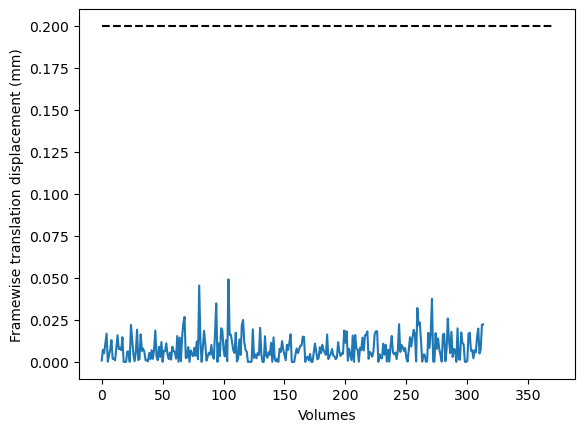

In [25]:
import matplotlib.pyplot as plt
#%matplotlib inline

# Getting the translation and computing the interframe difference  
trans_x = mot_params["Translation x"]
disp_x = np.diff(trans_x)

# Thresholding in absolute value above 0.2mm 
threshold=0.2

#Plotting
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

In [26]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere

    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [27]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

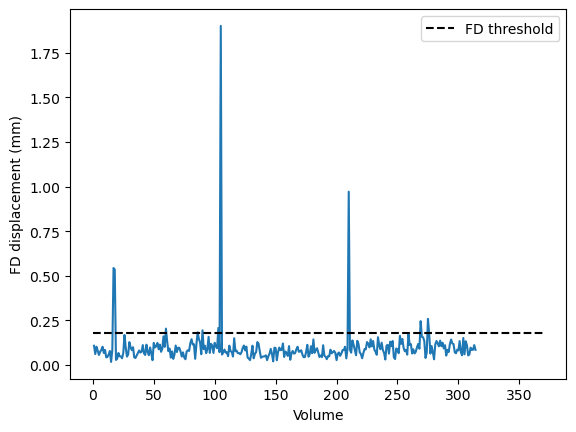

In [28]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [29]:
np.where(fd > threshold)[0] + 1

array([ 17,  18,  60,  86,  90, 103, 105, 210, 269, 275])

### 1.3.PP2 - Smoothing

In [31]:
output_path = op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco_smoothed-6mm'], returncode=0)

In [32]:
fsleyesDisplay.load(output_path + '_smoothed-6mm')

In [33]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ func/
|--------------- concatenated_bold.nii.gz
|--------------- concatenated_bold_moco.nii.gz
|--------------- concatenated_bold_moco.par
|--------------- concatenated_bold_moco_smoothed-6mm.nii.gz
|--------------- concatenated_standardized_fmri.nii.gz
|--------------- concatenated_bold_moco.mat/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


In [34]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))

# ---- End of pre-processing ------

## Design Matrix

In [ ]:
# Code from Lab05
from nilearn.image import concat_imgs, mean_img
fmri_img = concat_imgs(subject_data.func)
events = pd.read_table(subject_data['events'])
events

In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)

In [ ]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()